# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:** 

In the initial state, the smartcab simply stays in its initial state and does not move.  It gets positive rewards when the light in front of it is red (i.e. it's good that it isn't moving at a red light) but it gets negative rewards for just sitting at a green light.  In one case, I believe that I noticed it getting a positive reward for idling at a green light when there was cross-traffic (though I can't be certain -- I noticed it out of the corner of my eye while I was typing up this response ... In any case, it _should_ get a positive reward for not crashing into another car, even if there is a green light.)

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**
> *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*

1. `num_dummies` is a parameter of the `Environment` class that influences how many angents there should be in the simulation.
1. `grid_size` is a parameter of the `Environment` class that influences how many intersections there are.  It should be a 2-tuple
1. `learning` is a boolean parameter of the `LearningAgent` class that determines whether the agent should use `Q` learning.  Normally, it looks like that paramter is actually going to be passed to `Environment.create_agent` which will then pass it on to `LearningAgent`.  This seems like a silly API to me<sup>1</sup>, but whatever...

<sup><sup>1</sup>I'd probably have provided an `Environment.add_agent` method and force the _caller_ to create an appropriate agent instance.</sup>

> - *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*

[`act`](https://github.com/udacity/machine-learning/blob/master/projects/smartcab/smartcab/environment.py#L262) (line 262).

> - *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*

`render` displays the GUI simulation, `render_text` displays the simulation in terminal/text-based output.

> - *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

East-West is checked first (at line 39).  North-South checking starts at line 59.


-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'Left'` (turn left), `'Right'` (turn right), or `'Forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


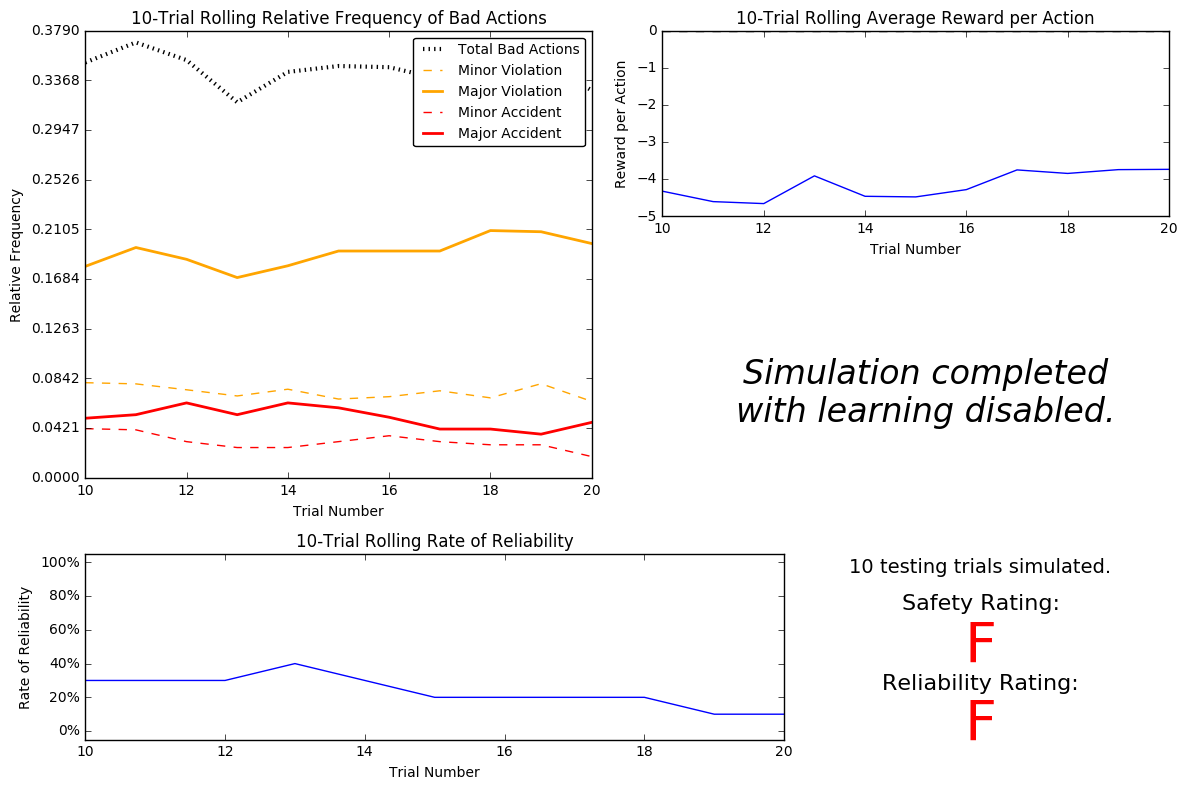

In [3]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliabilty make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

* The driving agent is making lots of bad decisions.  The actual number of bad decisions depends on the specific run.  In this case, it is ~35%.  It looks like somewhere around 10% of those bad decisions lead to minor or major accidents.
* Our rate of reliability is low -- really low.  I would expect it to be somewhere around 25% (there are 4 actions to pick, so we _should_ guess right approximately 25% of the time).  Looking at the chart, I think that we're roughly in that ballpark (some trials are better and some worse, but on average I think that's about right)
* Our driver's average reward is somewhere around -4.  Since the driver gets positive reward for making good choices, this indicates that the driver is making poor choices -- And probably lots of them (although, without know exactly how the rewards are given, it could also mean that the driver is making a few really bad choices as well).  Given the nature of how we are choosing actions, I strongly suspect that it is lots of bad choices, but looking at the code, a major accident gives a reward of -40 so that can pretty quickly decrease the average reward as well.
* As the trials increase, the outcomes stay pretty similar.  There is some variability (the reliability decreases a bit), but that is likely to just be due to the random nature of the simulation.
* This smartcab is neither safe, nor reliable.  It very rarely gets where it is supposed to go in an appropriate amount of time and it frequently gets in accidents along the way.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate?*

**Answer:**  Most of the features seem to be important for safety or efficiency or both.

* `waypoint`: If the smartcab does not go in the right direction, it will not get to the destination _efficiently_.
* `light`: If the smartcap runs a red-light, it won't be _safe_.
* `left`: If the smartcab knows when cars are turning, it can make safe decisions about when it should turn simultaneously.  i.e. if a car approaching from the west is going to turn north, a smartcab travelling north can safely turn east.  This can help the smartcab to be more _efficient_.  Additionally, it can help the smartcab to be more safe too (assuming that we do not trust the other drivers to see us when we are approaching).
* `oncoming`: Like `left` and `right`, this can help smartcab to know when it should stop.  e.g. if smartcab is travelling North and the oncoming car is turning East, smartcab might want to slow down to make sure that the oncoming car sees it before proceeding.   Even if we trust the other agents completely, if smartcab is travelling North and wants to turn West and the oncoming car is travelling South and turning West, smartcab needs to yield to avoid an accident.

Not appropriate features.

* `right`: The smartcab does not need to worry about traffic from the right so long as that traffic is going to obey the rules.  If smart-cab has a red or green light, it can make a right turn without being influenced by the car on the right.  If smart cab is going to turn left or go straight, it needs to be at a green light -- In which case, the car on the right has a red light.  If the car on the right wants to turn right (the only way it can move from a red-light), it needs to yield to smartcab since smart cab has the right-of-way.
* `deadline`: The optimal path between two points very rarely depends on when we have to get there.  There are some cases where knowing the deadline might cause us to take risks we might not take otherwise (e.g. too much traffic, so try a side-route), however I think that it will be wise to start off training without this state (as introducing this feature dramatically increases the size of the state-space since `deadline` is an effectively continuous variable).

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the evironment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

* waypoint (3 -- left, right, forward)
* light (2 -- red, green)
* left (4 -- forward, left, right, None)
* oncoming (4 -- forward, left, right, None)

=> 96 states

It should be possible for smartcab to explore this state space almost in its entirety in a reasonable number of trials.  On average, it takes slightly over 8 picks to choose all 4 actions if we are picking randomly.  That means that we'll need to see each state approximately 8 times.  That should be reasonable with only about 100 states to explore.


### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the interative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.01). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

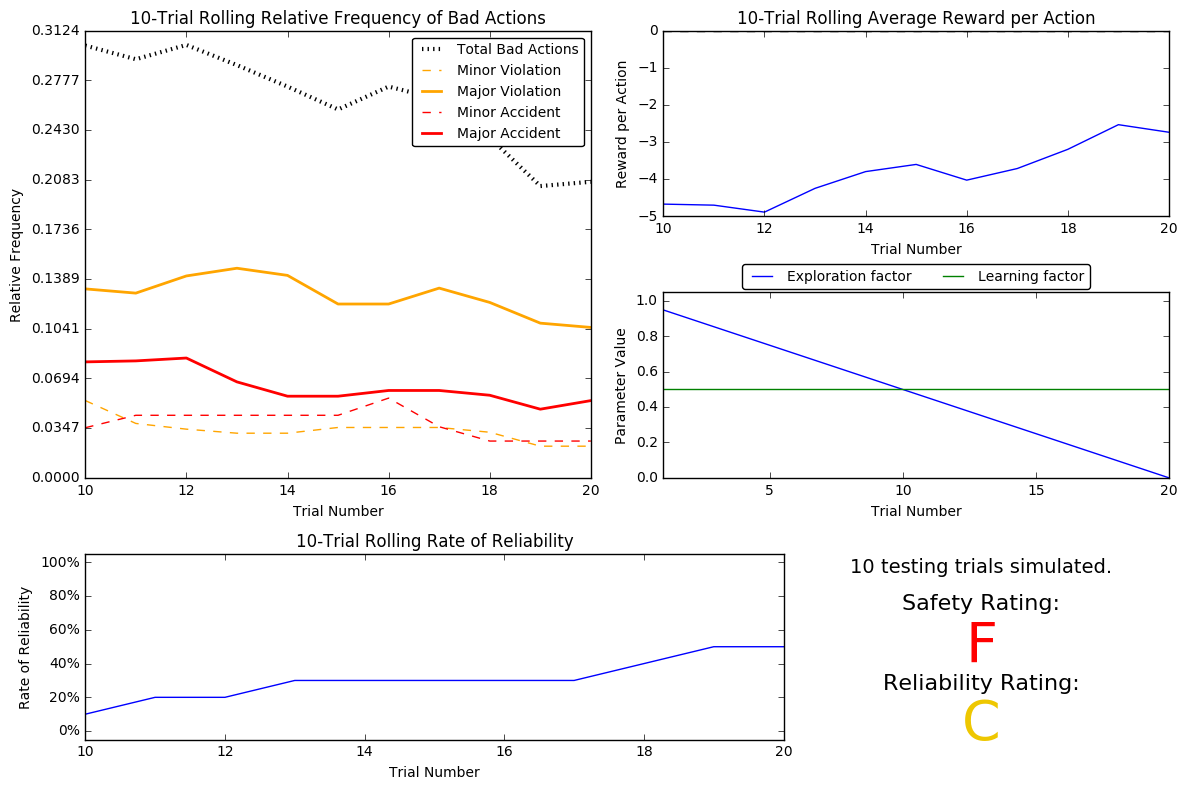

In [7]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**
There are similarities and differences between our learning agent and the basic driving agent we had before.  Specifically, looking at safety and reliability, our agent has gotten better at arriving at the destination (we're about 2x more reliable), unfortunately, we are still not getting there very safely (our major accident rate is nearly the same as it was before -- even in the later trials where the exploration factor is very small).  More concerning, we didn't learn how to decrease the major accidents as the trial numbers incraeased.

It does appear that learning did happen as evidenced by the upward trends in the reward/action and reliability graphs as well as the downward trends in the total bad actions as well as the major and minor traffic violations.

Our agent took approximately 20 trials before testing.  That makes sense because our exploration factor decreased from 1 to 0 over the course of 20 trials (decreasing by `.05` at each trial).  After the exploration factor (`epsilon`) reached zero, the model transitions from _exploring_ to _acting_ and therefore the tests start.



-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the impliciations it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

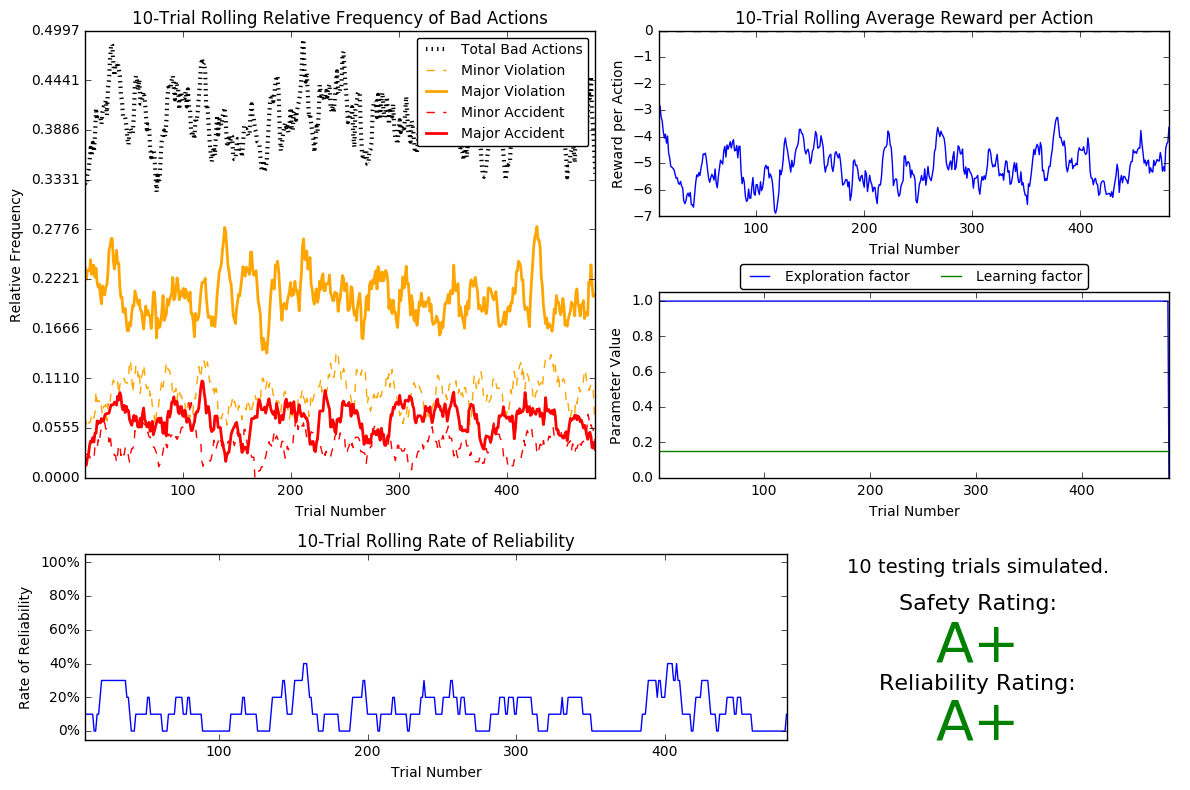

In [2]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

In the end, it seems like the trick to solving this one is to do _lots_ of exploration.  Smart exploration might also help to cut down on the number of iterations used to train.  For example, rather than selecting actions completely randomly, it seems to be more effective to randomly select actions that haven't previously been tried in that state.  In the end, I didn't use that approach though -- I just kept trying states until I had a vast majority of the state space mapped.

I implemented an epsilon function that was stepwise:

```
self.epsilon = (
   0.
   if self.get_percent_mapped() > .98 or (self.trial_number > 1000)
   else 1.)
```

where `self.get_percent_mapped()` returns the pecentage of items in `self.Q` that were non-zero.  In principle, the implementation of this function was flawed -- It only took into account the percentage of states that it had _seen_.  I did this somewhat intentionally to see how it might work for data where the total state space isn't necessarily known ahead of time or is actually to big to explore/store explicitly.

In the end this policy mapped approximately 98% of the states in about 500 trials.

Because of my training decay function, `alpha` didn't really matter.  Any arbitrary number greater than `0` but less than or equal to `1` would work.

This learner seemed to do an awesome job.  It managed to avoid all accidents and traffic violations and it reached the destination 100% of the time.

> Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?

Yes, I think that it learned _an_ appropriate policy.  I do not believe that it learned the _optimal_ policy, but the learned policy is probably good enough to get seed funding for my hypothetical self-driving car business...

> Are you satisfied with the safety and reliability ratings of the Smartcab?

As I said above, I doubt that this is the _optimal_ policy, so I'm not completely happy with it yet, but it's a pretty good start.

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8
Provide a few examples (using the states you've defined) of what an optimal policy for this problem would look like. Afterwards, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ Provide an example of a state and all state-action rewards recorded, and explain why it is the correct policy.

**Answer:** 

Here's an example of an clearly optimal policy given what information we can figure out from our state vector:

    ('forward', 'green', None, None)
     -- forward : 1.62
     -- right : 0.66
     -- None : -5.02
     -- left : 0.72

Smart cab is at a green-light by itself and the shortest distance is to go forward.  We can see that overwhelmingly, Smartcab thinks it should wait for the light to turn green.  Turning right or left has a positive weight (after all, it avoids a traffic accident that way), but it will likely take longer to reach the destination (barring traffic jams straight ahead that aren't part of our state)

Here's another example of an optimal policy:

    ('forward', 'red', None, None)
     -- forward : -11.81
     -- right : 0.45
     -- None : 1.69
     -- left : -13.50
 
Smart cab is at a red-light by itself and the shortest distanced is to go forward.  The right decision is to stay where it is.  `right` is also a valid (legal and safe) option, but since it is in the wrong direction, the weights are significantly smaller than the weights for staying where it is.  Note that both `left` and `forward` are illegal and dangerous actions and smart cab has learned to avoid those actions.

Here's an example of a possible sub-optimal policy

    ('right', 'red', 'right', 'right')
    -- forward : -7.10,
    -- None : 0.0,
    -- left : 0.0,
    -- right : 0.0

Note that smart-cab does not know if it should turn right, left or if it should stay where it is.  This is a little concerning and makes me think that we got a little lucky with our A+ safety rating.  It also makes me think that a slight improvement would be to teach smartcab to always choose `None` (stay where you are) over any other choice if it isn't sure...

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propogating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.